#### Импорт библиотек, необходимых в анализе данных

In [1]:
import pandas as pd
import numpy as np
import opendatasets as od

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (20,5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
plt.subplots_adjust(wspace=2,hspace=2)

<Figure size 1440x360 with 0 Axes>

# Context

#### Загружаем необходимый датасет с самого сайта +  загружаем csv файл

In [2]:
data_url = 'https://www.kaggle.com/c/tabular-playground-series-apr-2021/data'
od.download(data_url)
df = pd.read_csv('./tabular-playground-series-apr-2021/train.csv',encoding='windows-1252')

Skipping, found downloaded files in ".\tabular-playground-series-apr-2021" (use force=True to force download)


# Data quality assessment

#### Для начала необходимо посмотреть на данные: в каком порядке находятся, сколько пропущенных значений, какие строки/столбцы можно удалить или модифицировать

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


#### Основной целью исследования этого датасета - это выявление закономерностей имеющейся информации относительно того, выжил ли человек при крушении или нет. Исходя из описания данных выше, можно сделать вывод о том, что в основном все данные предоставлены почти в полном формате, за исключением столбца Cabin. Данный столбец предоставляет инфармацию о том, в какой каюте располагались люди. Так как в момент крушения корабль не мгновенно пошел ко дну, а сам удар пришелся не в каютный отсек, то можно предположить, что это информация нам не понадобится для отпределения закономерностей выживания людей и этот столбец можно удалить. По той же причине можно удалить столбец с  номером билетов пассажиров (Ticket).

In [5]:
df_main = df.drop(['Cabin','Ticket'], axis=1)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Fare         99866 non-null   float64
 9   Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(3)
memory usage: 7.6+ MB


#### Теперь у нас осталось 3 столбца с незаполненными данными и возможностью корреляции с выживанием при крушении, которые просто так не удалить. Это Age, Fare и Embarked. Попробуем для возраста применить медиану, как заполняющее значение, для цены билета - среднюю, а для порта отправки - самый частый порт, откуда совершалась посадка.

In [6]:
df_main['Age'] = df_main.Age.fillna(df_main.Age.median())
df_main['Fare'] = df_main.Fare.fillna(df_main.Age.mean())
df_main['Embarked'] = df_main.Embarked.fillna(df_main['Embarked'].value_counts().index.tolist()[0])
df_main.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1,1,"Oconnor, Frankie",male,39.00,2,0,27.14,S
1,1,0,3,"Bryan, Drew",male,39.00,0,0,13.35,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,71.29,S
3,3,0,3,"Kramer, James",male,19.00,0,0,13.04,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,7.76,S


#### Далее стоит проверить строки на наличие дупликатов (именно полных повторений строк, так как есть вероятность, что на борту будут однофамильцы).

In [7]:
df_main.drop_duplicates()
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          100000 non-null  float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Fare         100000 non-null  float64
 9   Embarked     100000 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 7.6+ MB


#### Дупликатов не было, поэтому можно считать, что данные готовы к дальнейшему анализу

# Data exploration

## 1. Описание индивидуальных переменных

### Переменные, имеющие узкие числинные диапазоны (Age,Fare)

[Text(0.5, 1.0, 'Количество выживших/погибших'),
 Text(0, 0.5, 'Кол-во людей'),
 Text(0.5, 0, 'Выжившие/погибшие')]

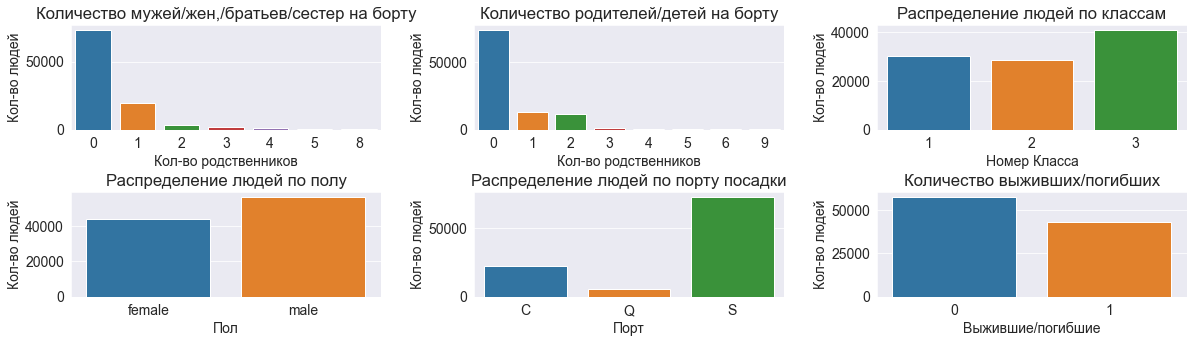

In [8]:
plt.subplots_adjust(wspace=0.3,hspace=0.6)
df_sib = df_main[['Survived','SibSp']].groupby('SibSp').count().reset_index()
df_par = df_main[['Survived','Parch']].groupby('Parch').count().reset_index()
df_class = df_main[['Survived','Pclass']].groupby('Pclass').count().reset_index()
df_sex = df_main[['Survived','Sex']].groupby('Sex').count().reset_index()
df_emb = df_main[['Survived','Embarked']].groupby('Embarked').count().reset_index()
df_surv = df_main['Survived'].value_counts()
plt.subplot(2,3,1)
sns.barplot(x = df_sib.SibSp,y=df_sib.Survived).set(title='Количество мужей/жен,/братьев/сестер на борту',ylabel='Кол-во людей',xlabel='Кол-во родственников')
plt.subplot(2,3,2)
sns.barplot(x = df_par.Parch,y=df_par.Survived).set(title='Количество родителей/детей на борту',ylabel='Кол-во людей',xlabel='Кол-во родственников')
plt.subplot(2,3,3)
sns.barplot(x = df_class.Pclass,y=df_class.Survived).set(title='Распределение людей по классам',ylabel='Кол-во людей',xlabel='Номер Класса')
plt.subplot(2,3,4)
sns.barplot(x = df_sex.Sex,y=df_sex.Survived).set(title='Распределение людей по полу',ylabel='Кол-во людей',xlabel='Пол')
plt.subplot(2,3,5)
sns.barplot(x = df_emb.Embarked,y=df_emb.Survived).set(title='Распределение людей по порту посадки',ylabel='Кол-во людей',xlabel='Порт')
plt.subplot(2,3,6)
sns.barplot(x = df_surv.index,y=df_surv).set(title='Количество выживших/погибших',ylabel='Кол-во людей',xlabel='Выжившие/погибшие')

#### Исходя из вышепредстваленных графиков можно уже сделать вывод о каждой переменной:
#### а.) Количество людей с родственниками 1 и 2 порядка на борту с увеличением количества уменьшается
#### б.) Количество людей в 3 классе больше, но незначительно (количество пассажиров по классу распределено практически равномерно)
#### в.) Мужчин на корабле было больше , но в % отношении не сильно большой перевес
#### г.) Основное количество людей село на борт в порту S
#### д.) В результате крушения больше погибших людей, чем выживших

### Переменные, имеющие широкие числинные распределения (Age,Fare)

<AxesSubplot:xlabel='Fare', ylabel='Count'>

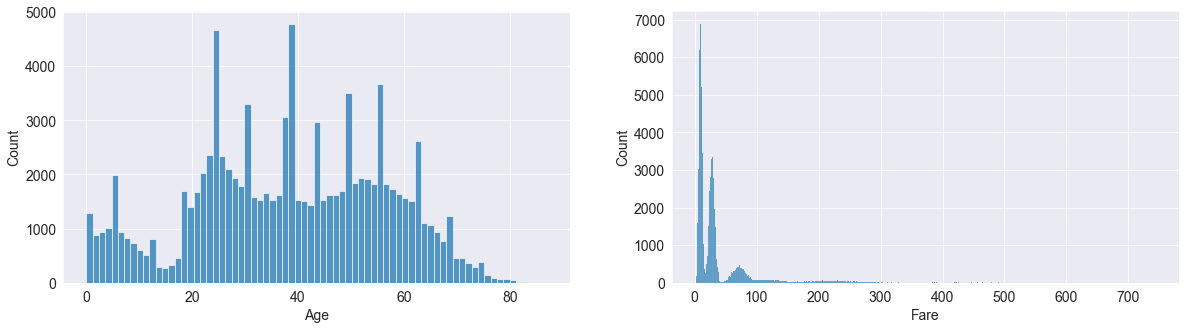

In [9]:
plt.subplot(1,2,1)
sns.histplot(df_main['Age'])
plt.subplot(1,2,2)
sns.histplot(df_main['Fare'])

#### В случае цены билета мы видим большой правосторонний хвост. При цене билета больше 300 их количество меньше 100, предполагаю, для лучшей визуализации этот хвост можно скрыть и показать данные меньше 300 у.е.

<AxesSubplot:xlabel='Fare', ylabel='Count'>

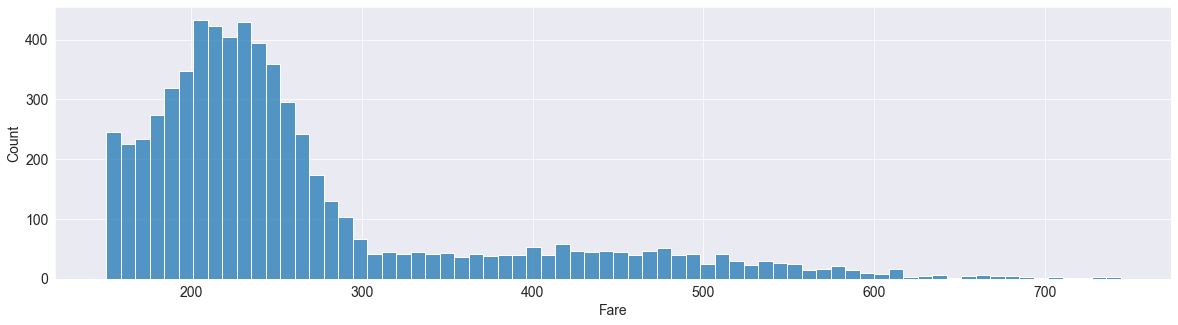

In [24]:
df_largefare = df_main[(df_main['Fare']>150)]
sns.histplot(df_largefare.Fare)

<AxesSubplot:xlabel='Fare', ylabel='Count'>

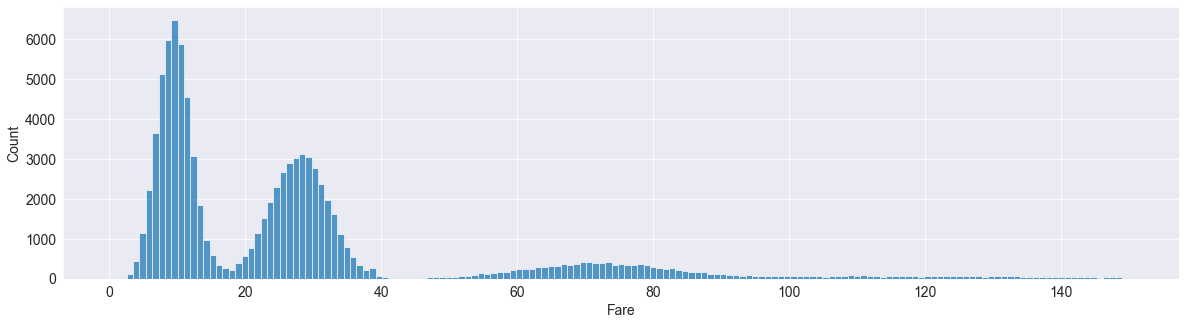

In [25]:
df_smallfare = df_main[(df_main['Fare']<150)]
sns.histplot(df_smallfare.Fare)

#### На графике цены билета можно увидеть тримодальное распределение, возможно, цена билета зависит от класса. Нужно это проверить в следующей части

### Взаимосвязь данных внутри датасета

#### Рассмотрим зависимость количества родственников 2 порядка (муж, жена, брат, сестра)

[Text(0.5, 1.0, 'Количество мужей/жен,/братьев/сестер на борту'),
 Text(0, 0.5, 'Кол-во людей'),
 Text(0.5, 0, 'Кол-во родственников'),
 (0.0, 1.0)]

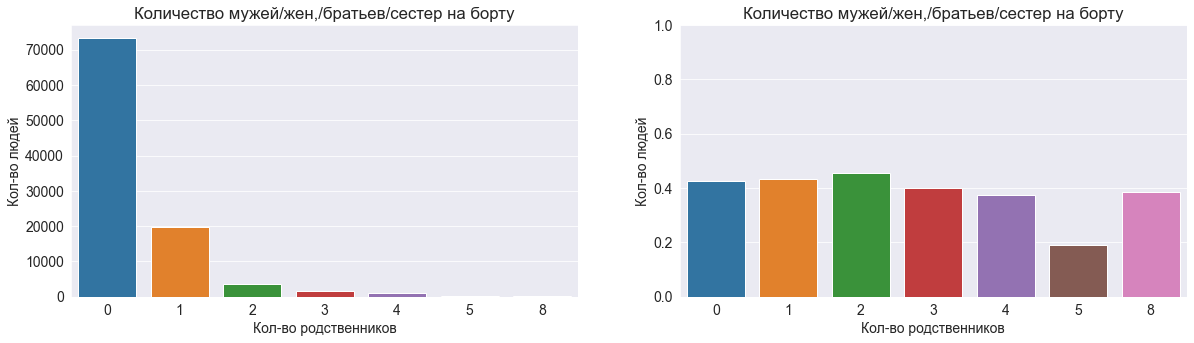

In [12]:
df_sib_agg = df_main[['Survived','SibSp']].groupby('SibSp').agg(['count','mean']).reset_index()
plt.subplot(1,2,1)
sns.barplot(x = df_sib_agg.SibSp,y=df_sib_agg.iloc[:,1]).set(title='Количество мужей/жен,/братьев/сестер на борту',ylabel='Кол-во людей',xlabel='Кол-во родственников')
plt.subplot(1,2,2)
sns.barplot(x = df_sib_agg.SibSp,y=df_sib_agg.iloc[:,2]).set(title='Количество мужей/жен,/братьев/сестер на борту',ylabel='Кол-во людей',xlabel='Кол-во родственников',ylim=(0,1))

#### Судя по всему, вероятность выжить зависит от количества родственников на борту, но проблема в том, что количество людей без родственников значительно превосходит количество людей с 5+ родственниками и возможно, что в целом обратная корреляция есть
#### Далее рассмотрим родственников 1 порядка (мать, отец, сын, доч)

[Text(0.5, 1.0, 'Количество родителей/детей на борту'),
 Text(0, 0.5, 'Кол-во людей'),
 Text(0.5, 0, 'Кол-во родственников'),
 (0.0, 1.0)]

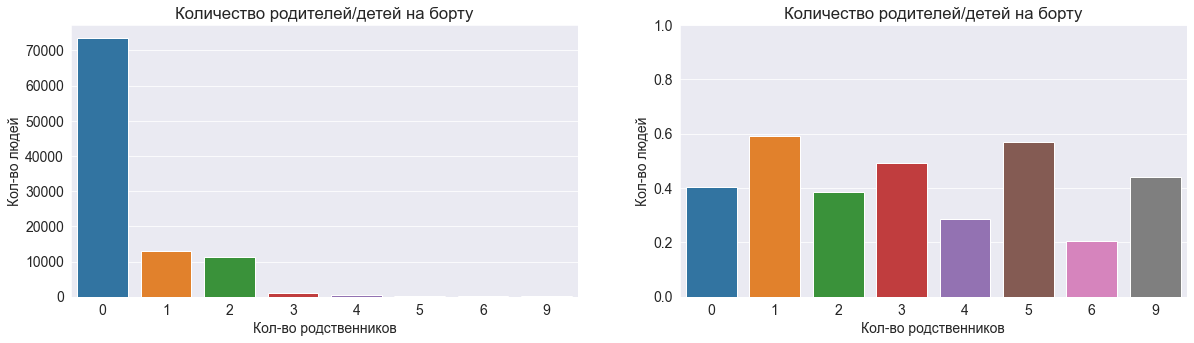

In [13]:
df_par_agg = df_main[['Survived','Parch']].groupby('Parch').agg(['count','mean']).reset_index()
plt.subplot(1,2,1)
sns.barplot(x = df_par_agg.Parch ,y=df_par_agg.iloc[:,1]).set(title='Количество родителей/детей на борту',ylabel='Кол-во людей',xlabel='Кол-во родственников')
plt.subplot(1,2,2)
sns.barplot(x = df_par_agg.Parch,y=df_par_agg.iloc[:,2]).set(title='Количество родителей/детей на борту',ylabel='% выживания',xlabel='Кол-во родственников',ylim=(0,1))

#### Как и в случае с родственниками 1 порядка, количество падает с увеличением этих родственников, а в случае с процентом выживаемости такая же картина, как и выше - тенденция к падению % выживаемости есть, но возможно, что было много семей, которых первыми сажали в лодки целиком, в том числе и многодетные и т.д. Поэтому можно сделать вывод о том, что обратная корреляция количества родственников к % выживания есть
#### Рассмотрим возрастное распределение

<AxesSubplot:xlabel='Age', ylabel='Survived'>

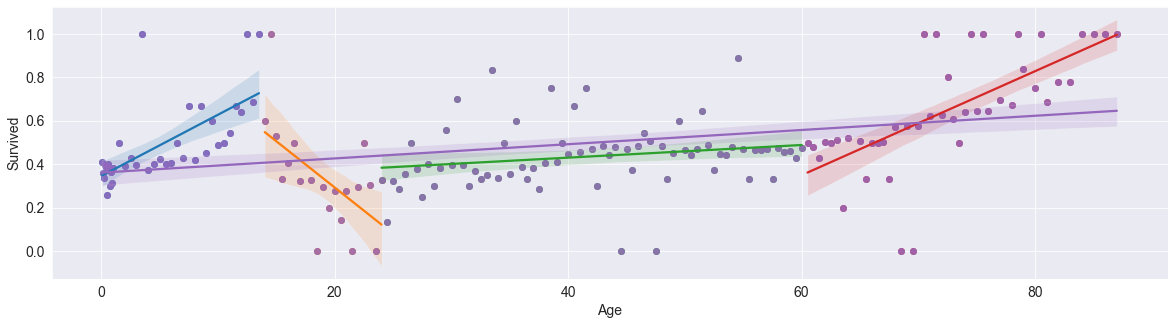

In [61]:
df_age = df_main[['Age','Survived']].groupby(['Age']).mean().reset_index()
df_baby = df_age[df_age['Age']<14]
df_young = df_age[(df_age['Age']>=14) & (df_age['Age']<=24)]
df_med = df_age[(df_age['Age']>=24) & (df_age['Age']<=60)]
df_old = df_age[(df_age['Age']>60)]
sns.regplot(x=df_baby['Age'],y=df_baby['Survived'])
sns.regplot(x=df_young['Age'],y=df_young['Survived'])
sns.regplot(x=df_med['Age'],y=df_med['Survived'])
sns.regplot(x=df_old['Age'],y=df_old['Survived'])
sns.regplot(x=df_age['Age'],y=df_age['Survived'])

#### Интересное наблюдение, что среди всех возрастных групп есть положительная корреляция к тому, что с увеличением возраста, увеличивается и выживаемость, но самая яркая зависимость - для пожилых лиц и для детей младше 14 лет. Это может быть связано с тем, что стариков вместе с детьмы пытались спасти первыми, тогда как молодые помогали или шли в конце списка, особенно исходя из отрицательного наклона линии пассажиров с 14 до 24 лет
#### Рассмотрим выживаемость в зависимости от пола

[Text(0, 0.5, '%'), Text(0.5, 0, 'Погибли - 0, Выжили - 1')]

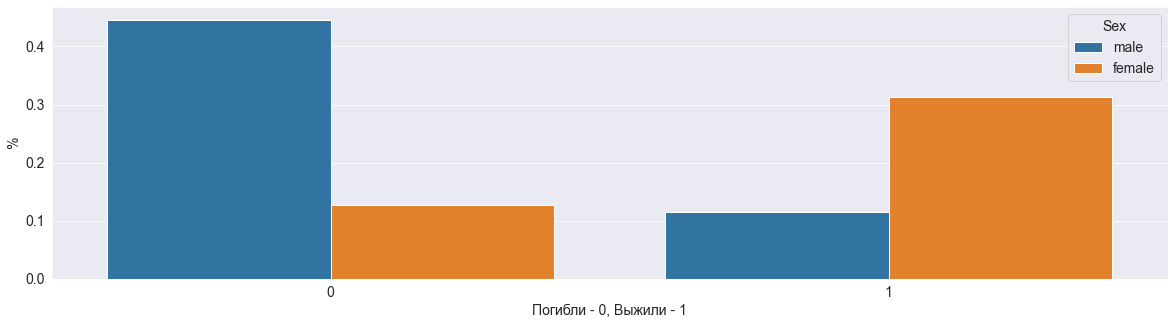

In [15]:
df_sex = df_main[['Survived','Sex']]
new_df = df_sex.value_counts(normalize=True).reset_index()
sns.barplot(x=new_df.iloc[:,0],y=new_df.iloc[:,2],hue=new_df.iloc[:,1]).set(ylabel='%',xlabel='Погибли - 0, Выжили - 1')

#### Рассмотрим выживание в зависимости от класса пассажиров

[Text(0, 0.5, '% выживания'), Text(0.5, 0, 'Номер класса')]

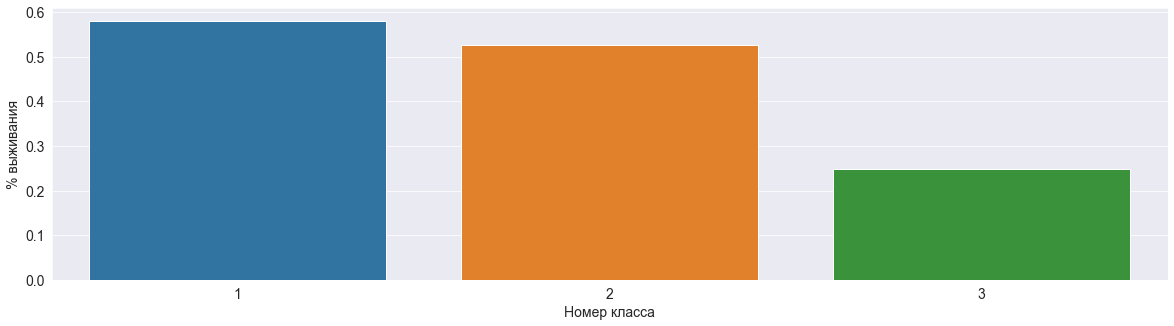

In [16]:
df_class =  df_main[['Survived','Pclass']].groupby('Pclass').agg(['count','mean']).reset_index()
sns.barplot(x=df_class.iloc[:,0],y=df_class.iloc[:,2]).set(ylabel='% выживания', xlabel='Номер класса')

#### Выживаемость в зависимости от порта посадки

[Text(0, 0.5, '% выживания'), Text(0.5, 0, 'Посадочный порт')]

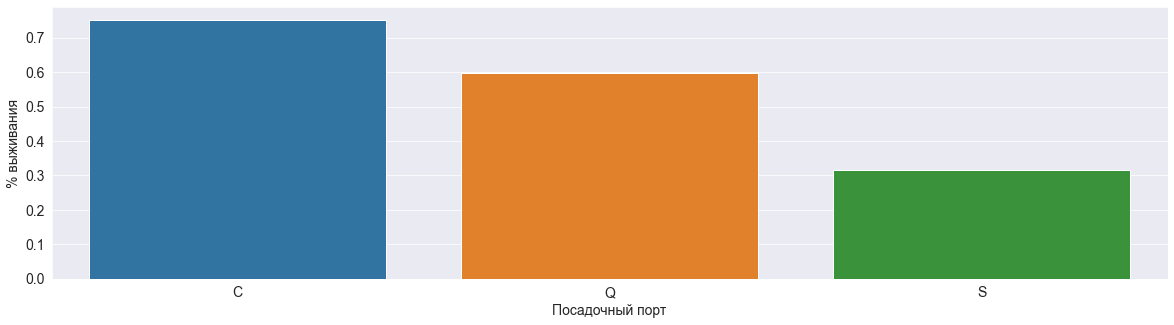

In [17]:
df_emb = df_main[['Survived','Embarked']].groupby('Embarked').agg(['count','mean']).reset_index()
sns.barplot(x=df_emb.iloc[:,0],y=df_emb.iloc[:,2]).set(ylabel='% выживания', xlabel='Посадочный порт')

#### Исходя из графика ниже можно найти такую закономерность, что наибольшую выживаемость имеет 1 и 2 класс пассажиров, попавших на борт из порта С

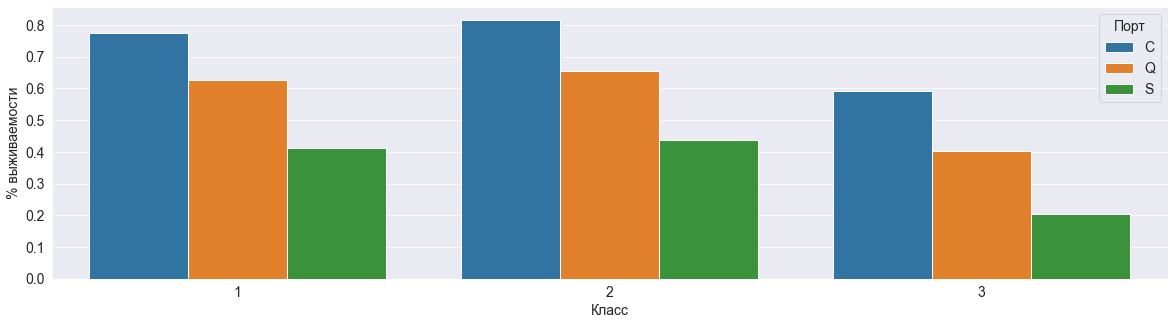

In [65]:
df_emb_class = df_main[['Survived','Embarked','Pclass']].groupby(['Embarked','Pclass']).agg(['count','mean']).reset_index()
sns.barplot(x=df_emb_class.iloc[:,1],y=df_emb_class.iloc[:,3], hue=df_emb_class.iloc[:,0]).set(xlabel='Класс', ylabel='% выживаемости')
plt.legend(title='Порт')

#### Рассмотрим корреляцию по возможной выживаемости и стоимости билета

#### Прежде всего рассмотрим взаимосвязь цены от класса пассажиров

<AxesSubplot:xlabel='Fare', ylabel='Count'>

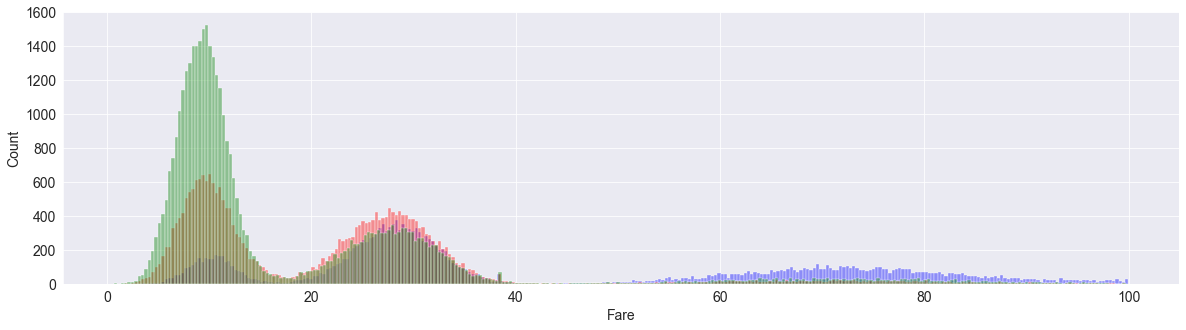

In [43]:
sns.histplot(df_main[(df_main['Pclass'] == 1) & (df_main['Fare'] < 100)].Fare, color='b',alpha=0.4,bins=300)
sns.histplot(df_main[(df_main['Pclass'] == 2) & (df_main['Fare'] < 100)].Fare, color='r', alpha=0.4,bins=300)
sns.histplot(df_main[(df_main['Pclass'] == 3) & (df_main['Fare'] < 100)].Fare, color='g', alpha=0.4,bins=300)

#### 3 моды, которые видны на графике не являются зависимостью цен и класса пассажиров, то есть в каждом ценовом диапазоне (0-18, 18-40, 40-100) есть все классовые преставители, но тенденция роста цен и количества купленных билетов с уменьшением класса (улучшением класса пассажиров) заметна
#### Рассмотрим % выживания и цену билета исходя из 5 ценовых диапазонов  (0-18, 18-40, 40-100, 100-300, 300+)

In [57]:
df_fare = df_main[['Fare','Survived']].groupby(['Fare']).mean().reset_index()
df_fare['Fare'] = round(df_fare['Fare']).astype('int32')
df_fare = df_fare.groupby(['Fare']).agg(['mean','count']).reset_index()
df_low_fare = df_fare[(df_fare.iloc[:,0]<19)]
df_med_fare = df_fare[(df_fare.iloc[:,0]>18) & ((df_fare.iloc[:,0]<41))]
df_100_300_fare =  df_fare[(df_fare.iloc[:,0]>101) & ((df_fare.iloc[:,0]<300))]
df_301_fare =  df_fare[(df_fare.iloc[:,0]>301)]

[Text(0, 0.5, 'Выживание'), Text(0.5, 0, 'Цена билета')]

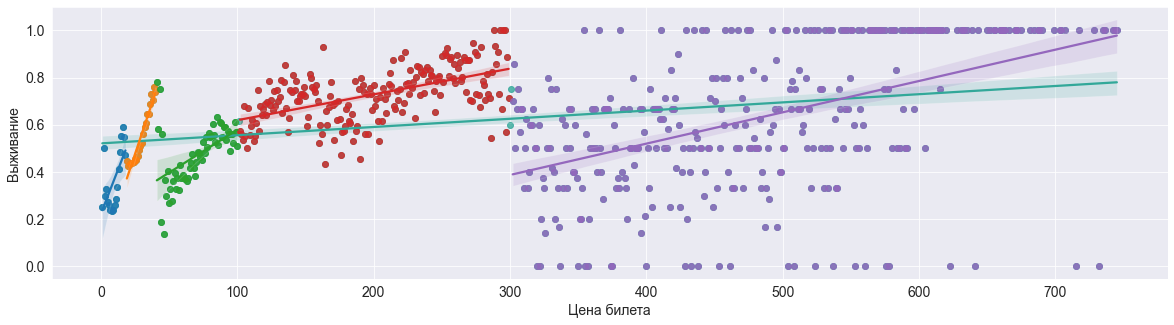

In [60]:
sns.regplot(x=df_fare.iloc[:,0],y=df_fare.iloc[:,1],color='#32a899')
sns.regplot(x=df_low_fare.iloc[:,0],y=df_low_fare.iloc[:,1])
sns.regplot(x=df_med_fare.iloc[:,0],y=df_med_fare.iloc[:,1])
sns.regplot(x=df_hight_fare.iloc[:,0],y=df_hight_fare.iloc[:,1])
sns.regplot(x=df_100_300_fare.iloc[:,0],y=df_100_300_fare.iloc[:,1])
sns.regplot(x=df_301_fare.iloc[:,0],y=df_301_fare.iloc[:,1]).set(ylabel='Выживание',xlabel='Цена билета')

#### Как видно исходя из графика, есть 5 основных групп ценовых данных. Если смотреть в общей совокупности, то есть средняя положительная корреляция (рост цены увеличивает рост выживаемости). Но если смотреть по группам, то наклон прямой уменьшается (скорее всего с ростом размера диапазона и с уменьшением количества билетов с большой ценой). Помимо всего прочего, стоит заметить, что средняя выживаемость людей с билетами в ценовом диапазоне от 100 до 300 намного выше среди всех других преставителей

# Summary

#### В общем и целом можно сделать сделать вывод о том, что зависимость выживания от каждого фактора есть. По каждому фактору сделаем общий вывод:
#### 1.) Количество погибших людей превосходит количество выживших.
#### 2.) Количество выживших женщин намного больше, чем мужчин. Основная идея этой закономерности в том, что женщин первых садили на борт.
#### 3.) Выживаемость так же не одинаковая и среди классов. Чем лучше класс, тем выше выживаемость ( для 1 и 2 класса выживаемость приблизительно одинаковая, а в сильную просадку попал 3 класс.
#### 4.) Была замечена так же такая тенценция, что порт S посадил самое большое количество людей на корабль и при этом выживаемость людей была самая маленькая, что можно сделать вывод о том, что самое большое количество пассажиров 3 класса было пасажено именно в этом порту.
#### 5.) Исходя из построенных графиков регрессии для возраста можно сделать выводы о том, что наиболее яркая зависимость (положительная) возраста и выживаемости - это старики и дети. Дети с минимальным возрастом имели отностильно небольшой процент выживаемости, т.к. младенцы не имеют хорошего иммунитета, а в океане было холодно, соответственно могли умереть даже при спасении с борта. Яркая тенденция наблюдается и с людьми с 14 до 24 лет (отрицательная) т.к. молодых людей эвакуировали в последнюю очередь.
#### 6.) Зависимость так же прослеживается и для ценовой категории. Самый оптимальный ценовой диапазон для наибольшего выживания - 100-300 у.е., что так же является преимущественно первым классом пассажиров.
#### 7.) Количество людей уменьшается с родственниками на борту с увеличением количества этих родственников. Общая выживаемость уменьшается, но не значительно (то есть шансы выжить приблизительно одинаковы). Это говорит о том, что если семья спасается полностью, спасается в половинном составе (дети, матери), либо не спасаются полностью.

### Исходя из вышеперечисленного можно сделать вывод о том, что наибольшие шансы имели выжить женщины из 1 и 2 класса, севшие на борт из порта С с ценой билета от 100 до 300 у.е. с 0-1 родственников на борту, в возрасте около 12-16 лет или в возрасте за 70 лет.
